In [1]:
import efficientnet

In [2]:
import os 
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# resizing the image
Size_X =384
Size_Y =384
n_classes = 2

In [4]:
#from keras.utils import normalize
import tensorflow as tf
import segmentation_models as sm
BACKBONE = 'efficientnetb4'
preprocess_input = sm.get_preprocessing(BACKBONE)

2022-06-04 09:08:04.860925: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


Segmentation Models: using `tf.keras` framework.


In [5]:
# define model
model = sm.PSPNet(BACKBONE, encoder_weights = None, classes =3 ,encoder_freeze=False, activation='sigmoid',input_shape=(Size_X,Size_Y,3), downsample_factor=8,psp_conv_filters=512, psp_pooling_type='avg',psp_use_batchnorm=True,psp_dropout=0.2)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.IOUScore(class_indexes=2,per_image=True),sm.metrics.FScore(class_indexes=2,per_image=True),sm.metrics.Precision(class_indexes=2),sm.metrics.Recall(class_indexes=2)],)
print(model.summary())

2022-06-04 09:08:06.267894: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-06-04 09:08:06.422639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-04 09:08:06.423633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-04 09:08:06.424566: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
pciBusID: 0000:81:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 384, 384, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 192, 192, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 192, 192, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 192, 192, 48) 0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [6]:
model.load_weights('weights/last/effb4_240_final.h5')

In [16]:
from tensorflow.python.compiler.tensorrt import trt_convert as trt
model.input.set_shape((1,) + model.input.shape[1:])
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.precision_mode = trt.TrtPrecisionMode.FP32 
converter.converted_save_suffix = '_TFTRT_FP32'
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_float_model_32 = converter.convert()
open("b4_lite1.tflite", "wb").write(tflite_float_model_32)

INFO:tensorflow:Assets written to: /tmp/tmpoxx7xgiz/assets


INFO:tensorflow:Assets written to: /tmp/tmpoxx7xgiz/assets
2022-06-04 09:22:40.025953: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 4
2022-06-04 09:22:40.026148: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2022-06-04 09:22:40.027863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-04 09:22:40.028683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 1 with properties: 
pciBusID: 0000:04:00.0 name: GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2022-06-04 09:22:40.029505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 2 with properties: 
p

8886788

In [17]:
float_model_32_size = len(tflite_float_model_32) / 1024

In [18]:
print(float_model_32_size)

8678.50390625


In [19]:
def gray2(mask):
    res=np.zeros((mask.shape[0],mask.shape[1]))
    for i in range (0,mask.shape[0]):
        for j in range (0,mask.shape[1]):
            l=np.argmax([mask[i,j,0],mask[i,j,1],mask[i,j,2]])
            res[i,j]=l
    res=res.astype(np.uint8)
    res = cv2.resize(res, (512, 512))
    return res


In [20]:
def Lite(lite_model,img):
    interpreter = tf.lite.Interpreter(model_content=lite_model)
    interpreter.allocate_tensors()
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    output = interpreter.get_tensor(output_index)
    return output

(1, 384, 384, 3)
(array([0, 1, 2], dtype=uint8), array([216865,  35860,   9419]))
inference time is:471.56572341918945ms
(array([0, 1, 2], dtype=uint8), array([216865,  35860,   9419]))
inference time is:49.771785736083984ms


[]

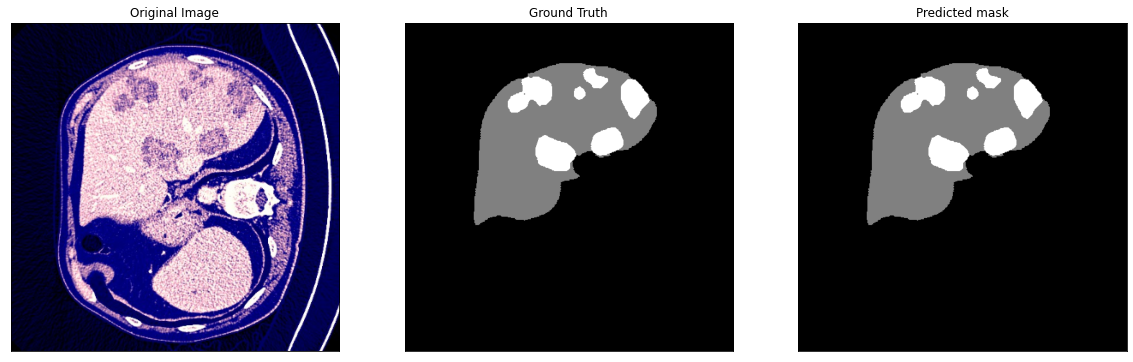

In [23]:
import time
#Test on a different image
#READ EXTERNAL IMAGE...

test_img = cv2.imread('new/Train_img/liver/volume-97_slice_568.jpg')       
test_img = cv2.resize(test_img, (Size_Y, Size_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img1 = np.expand_dims(test_img, axis=0)
print(test_img1.shape)
test_img2=test_img1.astype(np.float32)
start =time.time()
prediction = Lite(tflite_float_model_32,test_img2)
img1=prediction.reshape((Size_Y, Size_X,3))
end=time.time()
img=gray2(img1)
print(np.unique(img,return_counts=True))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

start =time.time()
prediction = model.predict(test_img1)
img2=prediction.reshape((Size_Y, Size_X,3))
end=time.time()
img2=gray2(img2)
print(np.unique(img2,return_counts=True))
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
inference=(end-start)*1000
print("inference time is:"+str(inference)+"ms")

mask_img = cv2.imread('new/Train_img/liver_mask/segmentation-97_slice_568.tiff',0)       
mask_img = cv2.resize(mask_img, (Size_Y, Size_X))
fig, ax= plt.subplots(1,3,figsize=(20, 20))
ax[0].imshow(test_img, cmap='gray')
ax[0].set(title='Original Image')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].imshow(img2, cmap='gray')
ax[1].set(title='Ground Truth')
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[2].imshow(img, cmap='gray')
ax[2].set(title='Predicted mask')
ax[2].xaxis.set_ticks([])
ax[2].yaxis.set_ticks([])

In [ ]:
def evaluate_tflite_model(tflite_model, test_images, test_labels):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()

    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    testimage_len = test_labels.shape[0]

    #for test_image in enumerate(test_images):
    for test_image in test_images:
        
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.reshape(test_image, (1, 1, 100)).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    print('\n')
    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    #print('Compare prediction')
    #print(prediction_digits)
    #print(test_labels)
    for i in range(testimage_len):
        if i < testimage_len/2:
           if prediction_digits[i] == 0:
              accurate_count += 1
        else:
           if prediction_digits[i] == 1:
              accurate_count += 1
    #print(testimage_len)
    #print(accurate_count)
    accuracy = accurate_count/testimage_len

    return accuracy